# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_zinc_padel_no_inputation.csv")
data.head()

/tmp/ipykernel_673921/139793699.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_zinc_padel_no_inputation.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,-1.387779e-17,0.000000e+00,8.452347e+00,2.113087,0.0,0.106,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 14:-1]
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,0.0,-0.4695,0.220430,11.1997,8.393965,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,0.0,-1.0852,1.177659,15.4305,9.557965,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,0.0,-1.0880,1.183744,12.5072,8.231172,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,0.0,-0.2157,0.046526,22.3381,12.187551,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.387779e-17,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,0.0,-0.5895,0.347510,11.3934,11.222758,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "padel_no_inputation"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,1.589644,-0.471861,-0.113926,0.274444,-0.018916,-0.688640,-0.037589,0.699850,0.358958,...,0.139306,0.439047,-0.214293,0.882237,0.088878,-0.073069,-0.111233,-0.118910,1.684356,-1.266726
1,1.0,-0.307889,0.071369,-0.267217,0.138519,0.565822,0.288403,-0.037589,0.151005,-0.452562,...,0.475769,-0.262519,0.554663,-0.415932,-0.038806,-0.193510,-0.111602,-0.119185,1.528091,1.336404
2,1.0,-0.307889,0.755612,-0.245551,-0.832186,-0.464498,0.776924,-0.037589,0.699850,-0.858321,...,0.265993,-0.593821,0.006986,0.305247,-0.922007,-0.975357,-0.111910,-0.119374,0.586097,0.105139
3,1.0,-0.307889,0.755274,-0.245620,-0.775622,-0.527695,0.776924,-0.037589,0.151005,-0.858321,...,0.264167,0.185904,1.281404,0.485166,-0.742335,-0.740689,-0.111879,-0.119336,0.586097,0.094980
4,1.0,-0.307889,0.946513,-0.196789,1.267409,0.392789,-1.665683,-0.037589,-1.495529,-0.452562,...,1.426982,2.449822,0.827118,4.384167,-1.022399,-1.100108,-0.111828,-0.119309,0.586097,1.264885


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.32633,0.199345,-0.283345,-1.290103,-1.083114,0.343155,-0.046029,0.174498,-1.320960,...,-1.187113,0.063247,-1.732759,-1.478945,-0.511331,-0.078567,-0.112298,-0.107327,-1.196177,-0.272743
1,1.0,-0.32633,0.021656,-0.265663,-0.627087,-0.853191,-0.659288,-0.046029,-0.911521,-0.893737,...,-2.495138,-2.046064,-1.732759,-1.478945,-0.608718,-0.306538,-0.112283,-0.107325,-1.196177,-0.139182
2,1.0,-0.32633,-0.082133,-0.247670,0.047487,0.205662,0.009007,-0.046029,0.174498,-0.466513,...,-0.675483,0.061228,-0.130570,0.297805,0.765072,0.772287,-0.111983,-0.107238,-1.196177,0.360727
3,1.0,-0.32633,-0.318916,-0.185463,-0.615731,0.635684,1.846818,-0.046029,0.717507,-0.893737,...,-0.049071,-0.731131,-0.761392,0.128601,-1.012055,-1.085787,-0.111701,-0.107178,0.574218,1.948796
4,1.0,-0.32633,0.362705,-0.284983,0.200763,0.131850,0.176081,-0.046029,0.717507,-0.466513,...,-0.622568,-0.748320,-0.206725,-0.307836,-0.154971,-0.172123,-0.112010,-0.107250,0.574218,-0.147975


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 23:11


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 23:11
Tempo de execução:  0.1 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.625886,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [14]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [15]:
# calculatin model
log_reg = sm.Logit(y_train, x_train_scaled).fit(method='bfgs')
log_reg_results = log_reg.summary()

         Current function value: 0.210866
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Get Training Error and AUC

In [16]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=log_reg, 
    x=x_train_scaled,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.0811
Training AUC: 0.9189


## Make Predictions

In [17]:
# the log_reg algorithm predicts as probabilities
y_predict_lr_prob = log_reg.predict(x_test_scaled)

In [18]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

## Test Error

In [19]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.1670


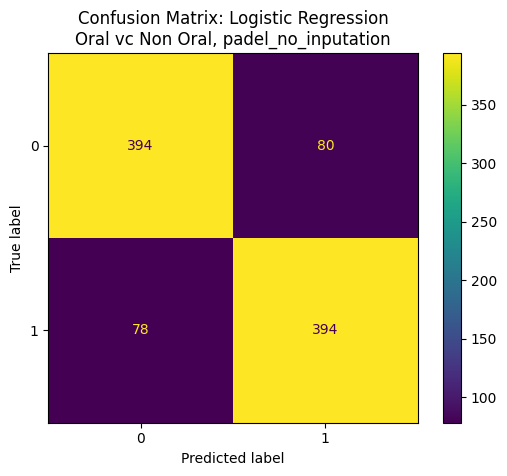

In [20]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

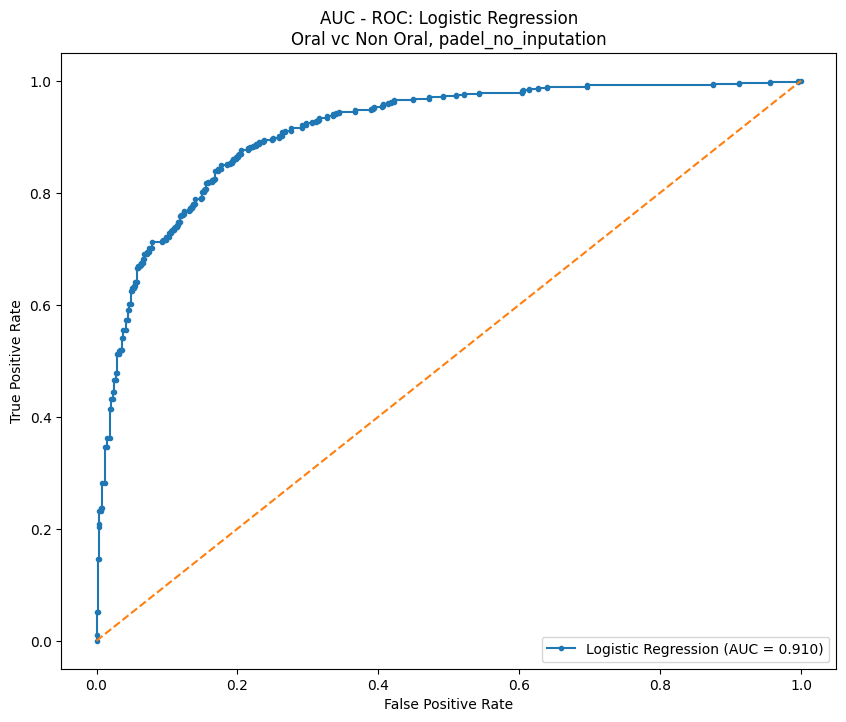

In [21]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [22]:
# converting results summary to pandas dataframe
results_log_reg_html = log_reg_results.tables[1].as_html()
results_log_reg_df = pd.read_html(results_log_reg_html, header=0, index_col=0)[0]
print(results_log_reg_df.shape)
results_log_reg_df.head()

(585, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
const,1.1998,NaN,NaN,NaN,NaN,NaN
nAcid,0.5550,NaN,NaN,NaN,NaN,NaN
ALogP,0.7349,NaN,NaN,NaN,NaN,NaN
ALogp2,-0.6589,NaN,NaN,NaN,NaN,NaN
AMR,-0.0561,NaN,NaN,NaN,NaN,NaN


In [23]:
important_features_lr = results_log_reg_df[results_log_reg_df["P>|z|"] < 0.05]
print(important_features_lr.shape)
important_features_lr

(0, 6)


,coef,std err,z,P>|z|,[0.025,0.975]


## Saving Results

In [24]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [25]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266


In [26]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 23:11
Finished Grid Search for Decision Tree: 00:01
Tempo de execução:  50.2 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.810729,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [33]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.1929
Training AUC: 0.8069


## Make Predictions

In [34]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [35]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.2294


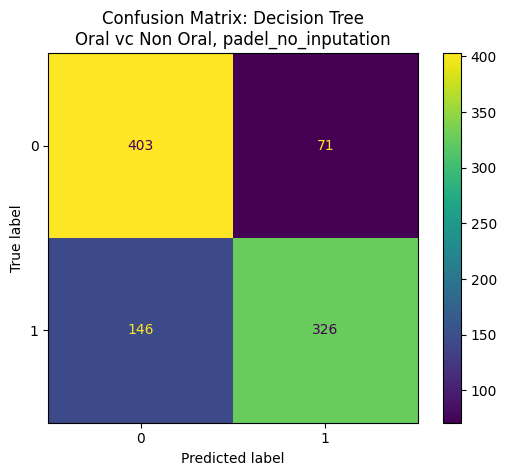

In [36]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

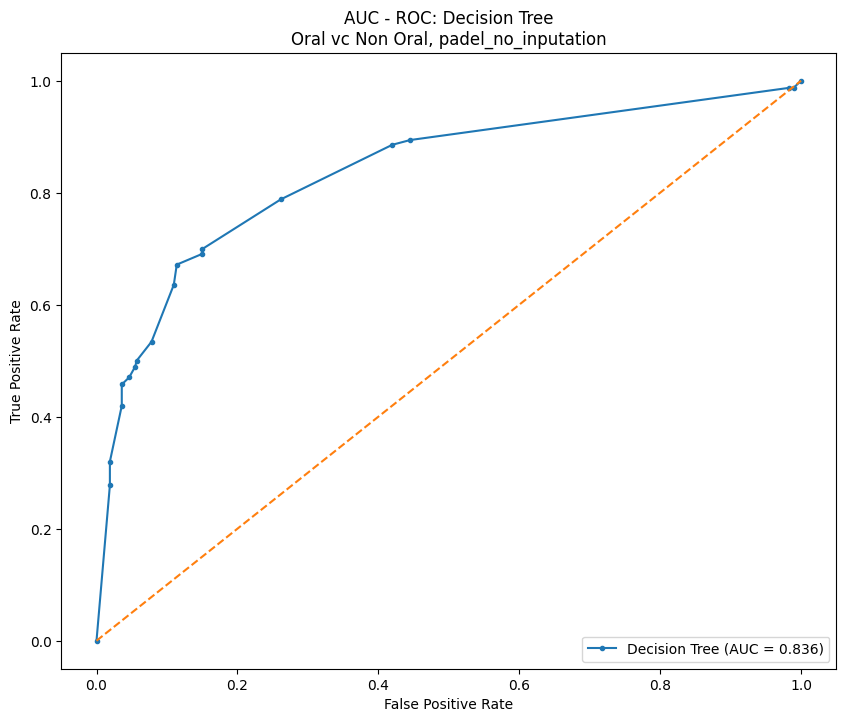

In [37]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

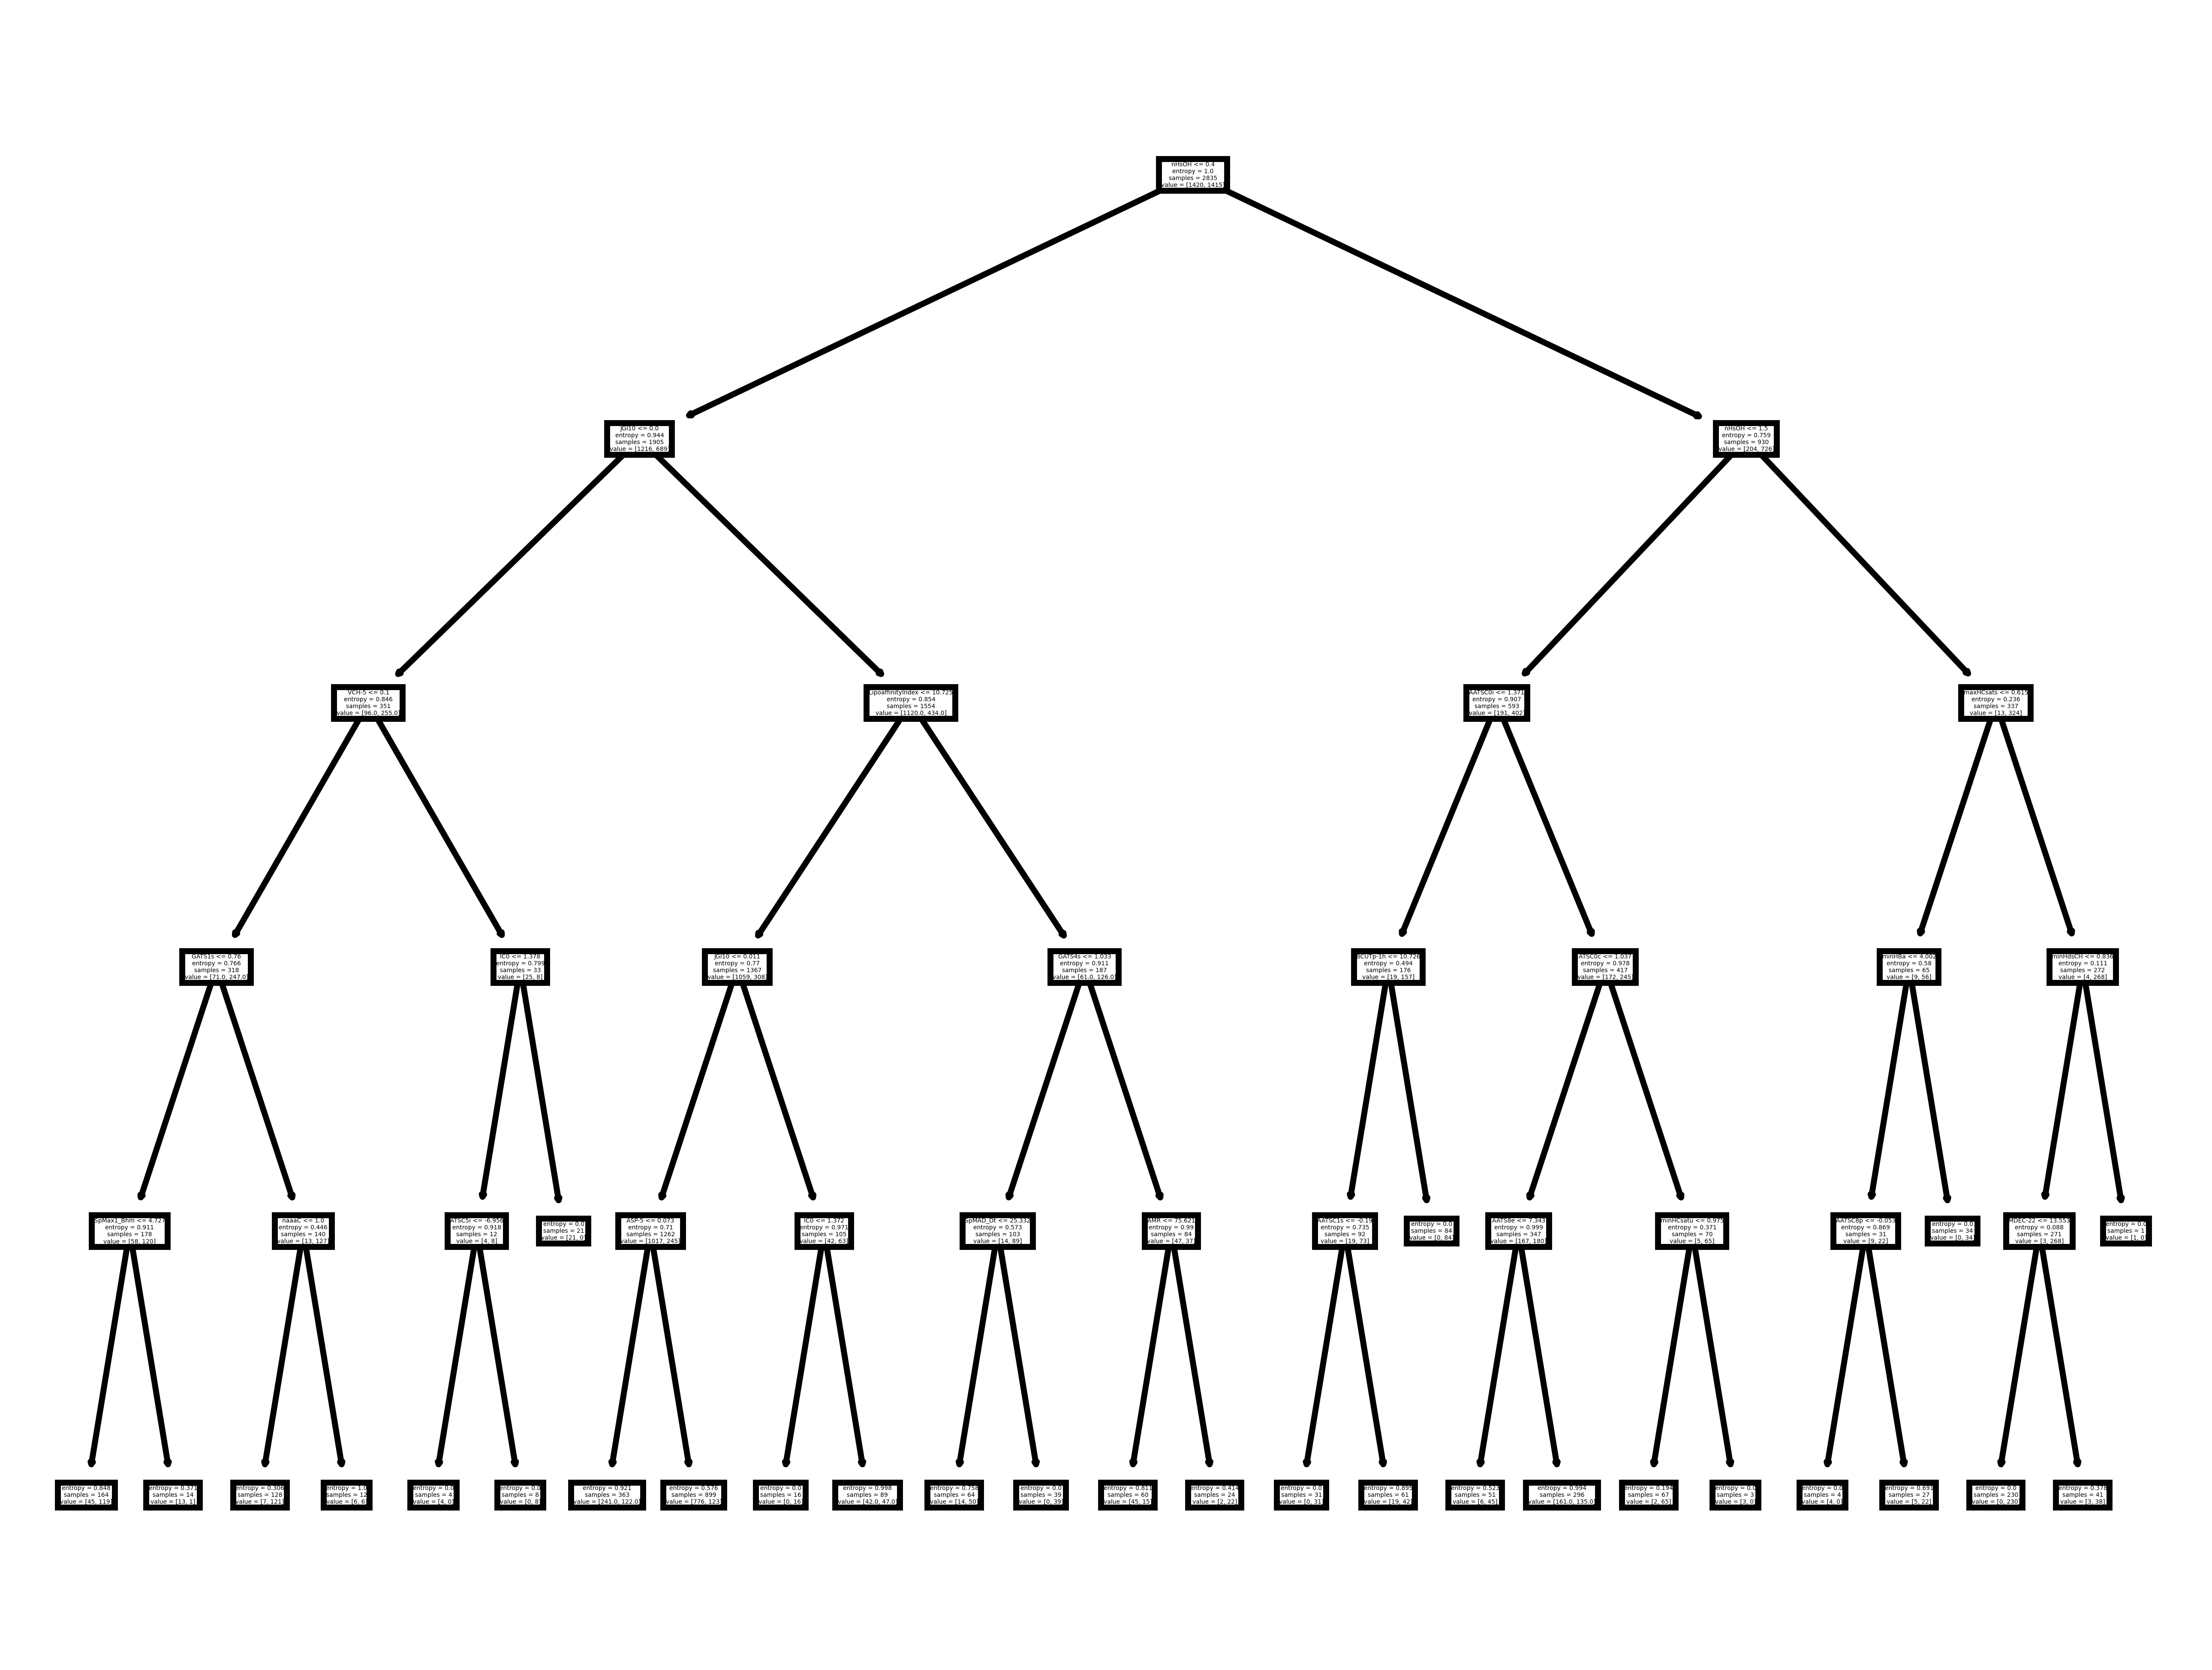

In [38]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

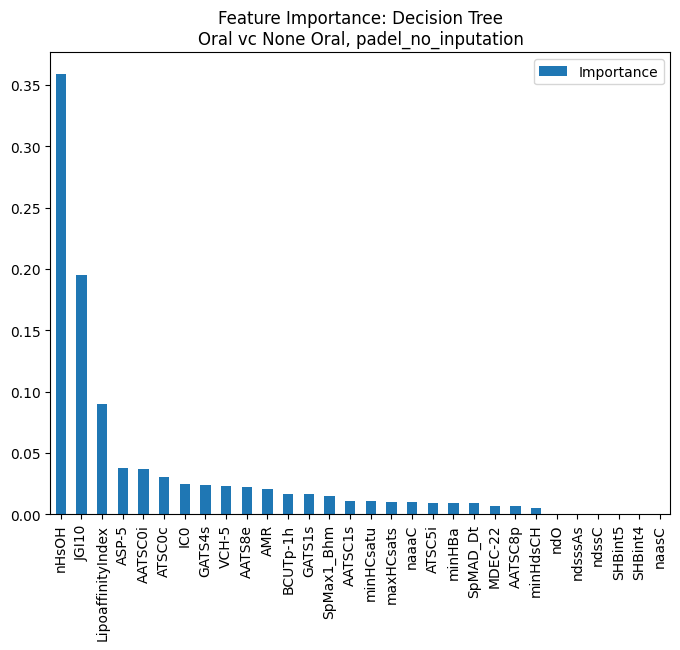

In [39]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [40]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
minHdsCH,0.005374
AATSC8p,0.007082
MDEC-22,0.007111
SpMAD_Dt,0.009035
minHBa,0.009213
ATSC5i,0.009427
naaaC,0.009637
maxHCsats,0.009964
minHCsatu,0.011131
AATSC1s,0.011132


## Saving Results

In [41]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266
1,Decision Tree,0.810729,0.192945,0.229387,0.806894,0.836344


In [42]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [43]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [44]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [45]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 00:02
Finished Grid Search for Random Forest: 04:21
Tempo de execução:  259.7 minutos


In [46]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.933841,"{'ccp_alpha': 0, 'max_depth': 50, 'max_feature..."


## Fitting Model

In [47]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 1000}

In [48]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [49]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0000
Training AUC: 1.0000


## Make Predictions

In [50]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [51]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.1237


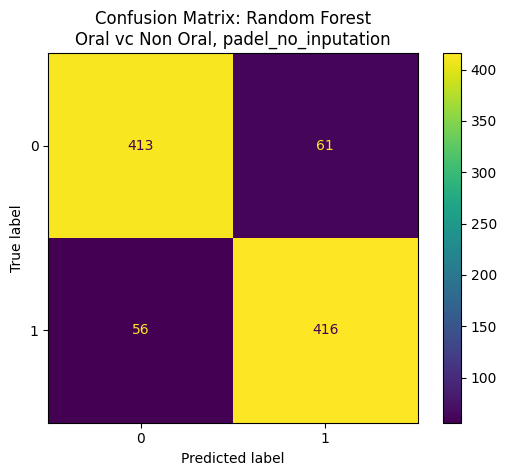

In [52]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

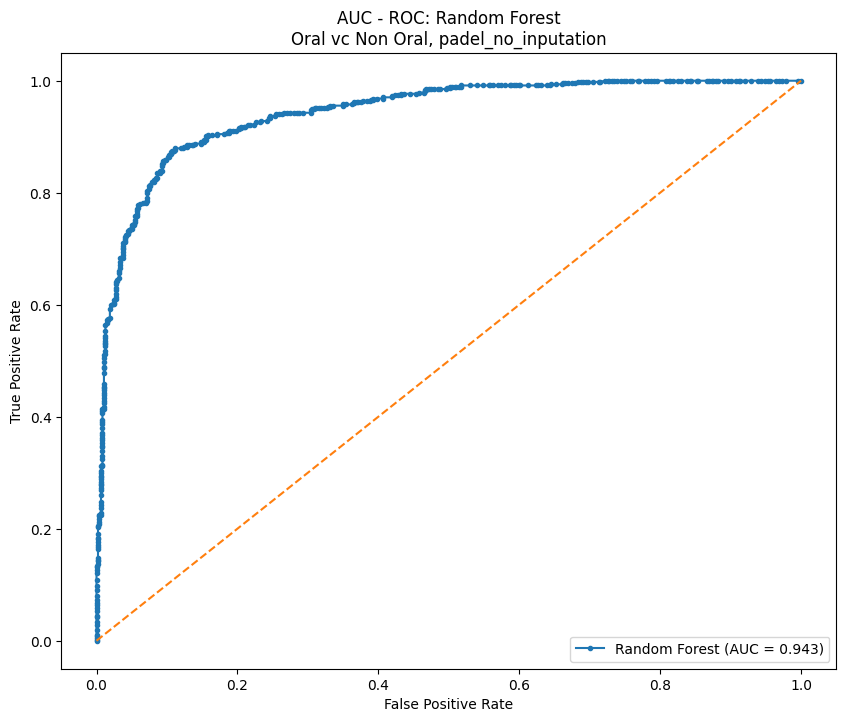

In [53]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

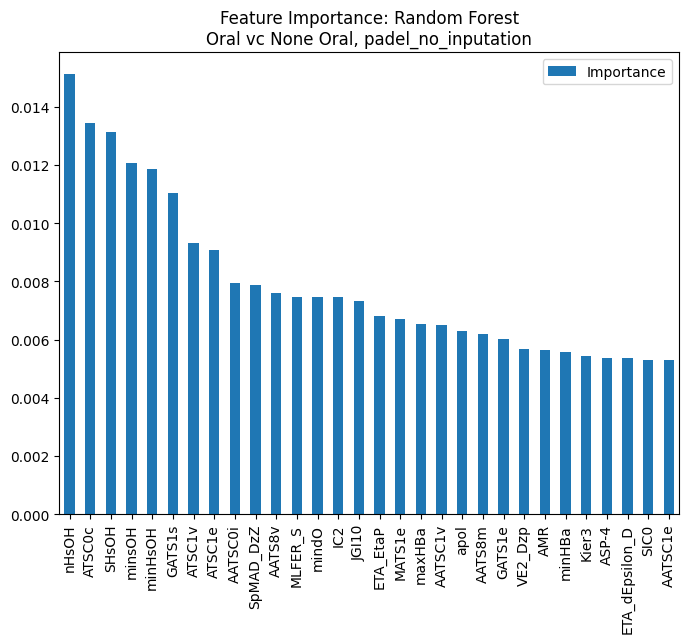

In [54]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [55]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
ndsssAs,0.000001
maxsSH,0.000001
nHtCH,0.000002
nI,0.000003
ETA_dPsi_B,0.000003
...,...
minHsOH,0.011854
minsOH,0.012075
SHsOH,0.013126
ATSC0c,0.013450


## Saving Results

In [56]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266
1,Decision Tree,0.810729,0.192945,0.229387,0.806894,0.836344
2,Random Forest,0.933841,0.000000,0.123679,1.000000,0.942991


In [57]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [58]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [59]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [60]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 04:22
Finished Grid Search for Boosting: 12:00
Tempo de execução:  457.5 minutos


In [61]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.868864,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [62]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [63]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [64]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0000
Training AUC: 1.0000


## Make Prediction

In [65]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [66]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.2410


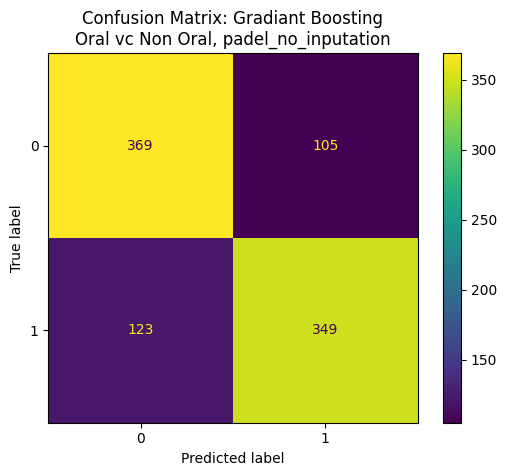

In [67]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

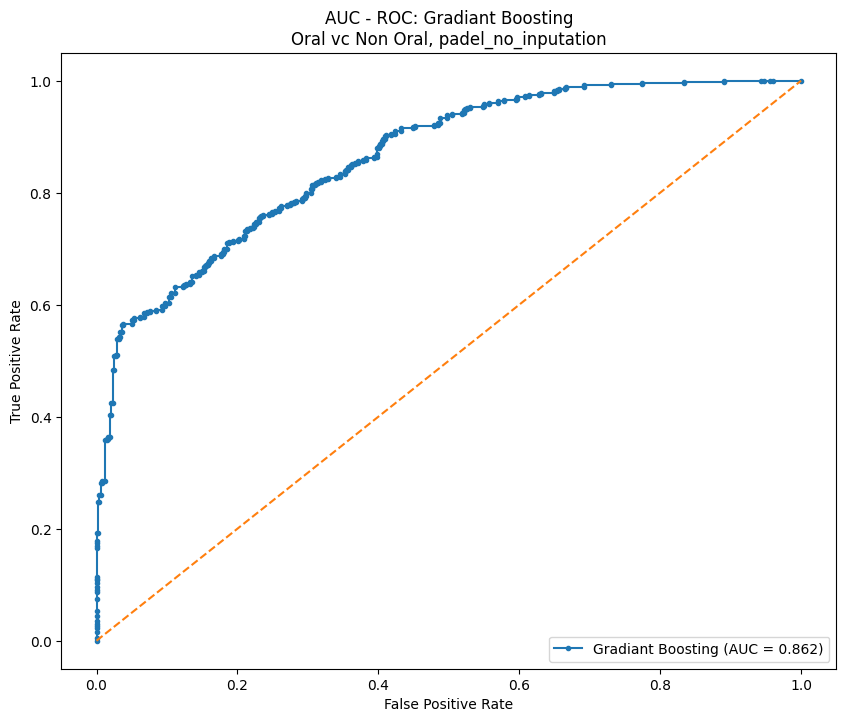

In [68]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

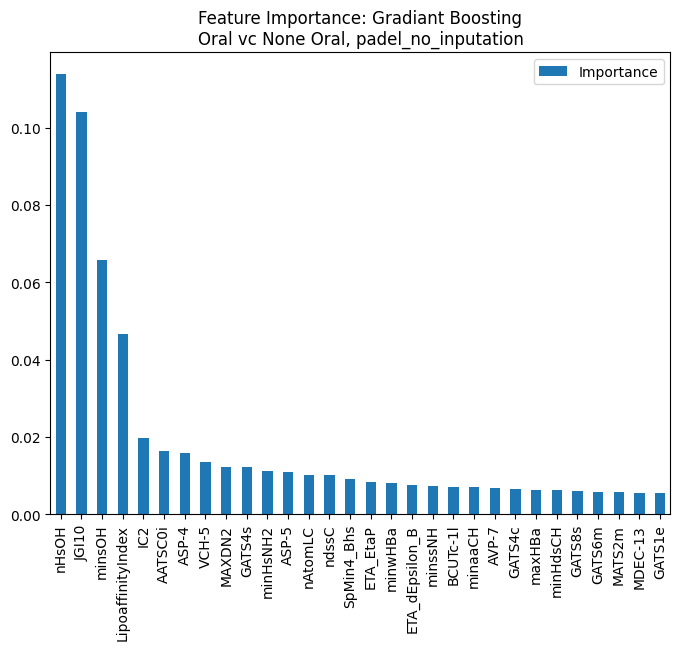

In [69]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [70]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
n8Ring,1.457067e-15
maxssssC,2.163893e-15
nHdNH,1.641911e-14
nwHBd,4.496340e-14
nF7Ring,7.880114e-14
...,...
IC2,1.981097e-02
LipoaffinityIndex,4.675563e-02
minsOH,6.586986e-02
JGI10,1.040826e-01


## Saving Results

In [71]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266
1,Decision Tree,0.810729,0.192945,0.229387,0.806894,0.836344
2,Random Forest,0.933841,0.000000,0.123679,1.000000,0.942991
3,Gradiant Boosting,0.868864,0.000000,0.241015,1.000000,0.861774


In [72]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [73]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [74]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [75]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [76]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 12:04
Finished Grid Search for BART: 18:16
Tempo de execução:  372.1 minutos


In [77]:
gs_result_bart

,model,best_score,best_params
0,BART,0.846668,"{'burnin': 10, 'max_stages': 800, 'num_trees':..."


# Fitting Model

In [78]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 10, 'max_stages': 800, 'num_trees': 1000}

In [79]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=10, max_stages=800, num_trees=1000)

## Get Training Error and AUC

In [80]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1150
Training AUC: 0.8850


## Make Prediction

In [81]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [82]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [83]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.1490


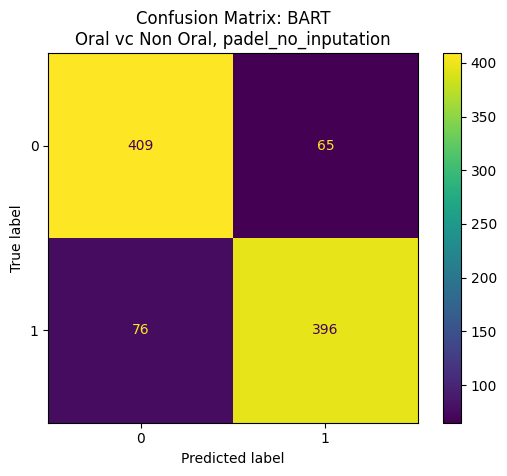

In [84]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

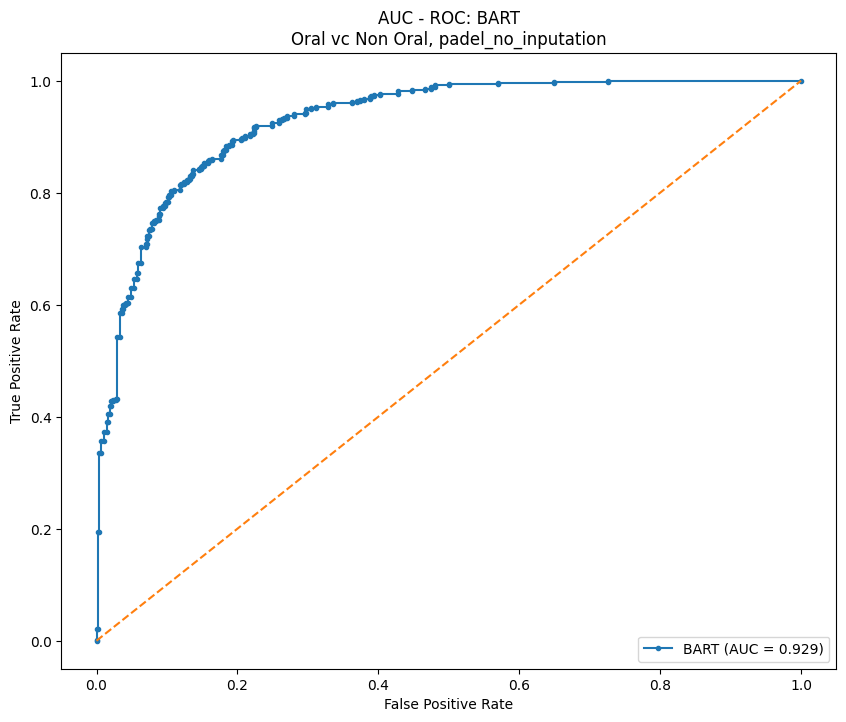

In [85]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

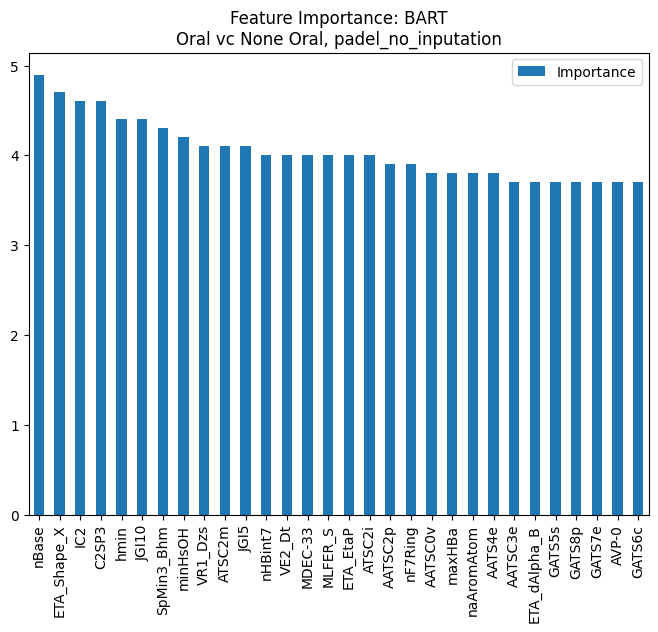

In [86]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [87]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
AATSC2e,1.1
AATS0p,1.2
SHBint6,1.2
maxHBint8,1.3
nAtomLAC,1.3
...,...
hmin,4.4
C2SP3,4.6
IC2,4.6
ETA_Shape_X,4.7


## Saving Results

In [88]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266
1,Decision Tree,0.810729,0.192945,0.229387,0.806894,0.836344
2,Random Forest,0.933841,0.000000,0.123679,1.000000,0.942991
3,Gradiant Boosting,0.868864,0.000000,0.241015,1.000000,0.861774
4,BART,0.846668,0.114991,0.149049,0.884990,0.928614


In [89]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [90]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [91]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [92]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 18:17
Finished Grid Search for SVM: 21:53
Tempo de execução:  216.1 minutos


## Fitting Model

In [93]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 2, 'gamma': 0.0001, 'kernel': 'rbf'}

In [94]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [95]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0000
Training AUC: 1.0000


## Make Prediction

In [96]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [97]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.4831


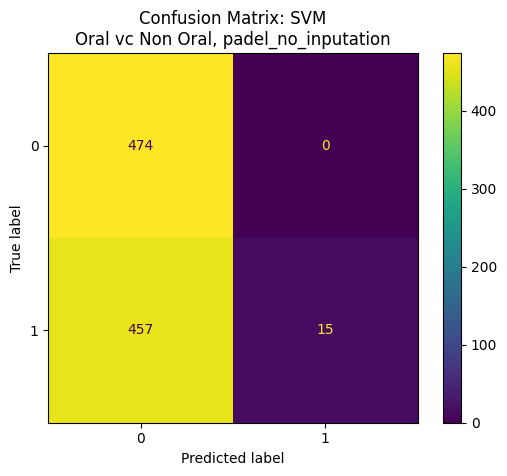

In [98]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

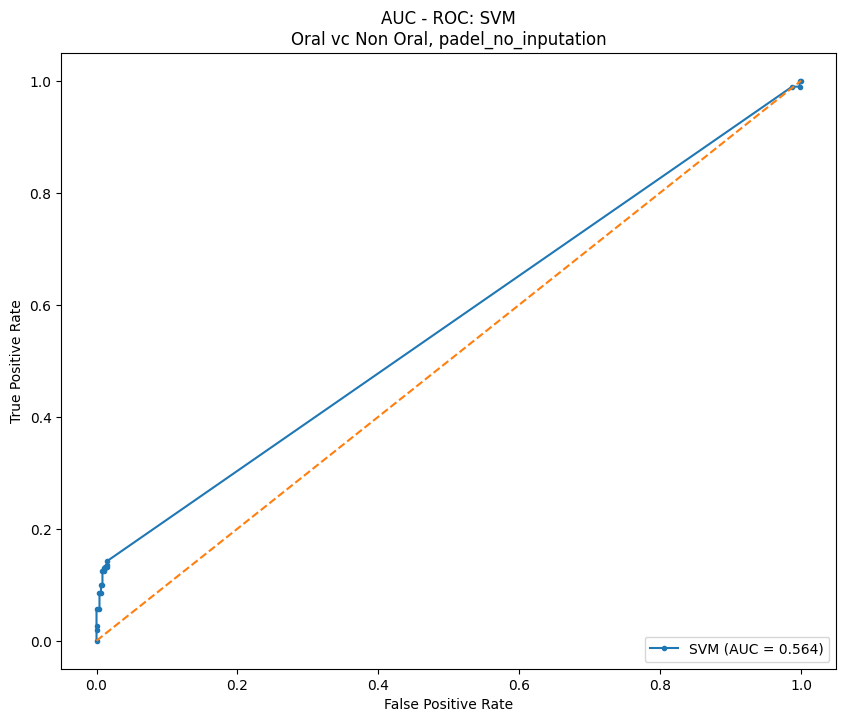

In [99]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [100]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.625886,0.081129,0.167019,0.918852,0.910266
1,Decision Tree,0.810729,0.192945,0.229387,0.806894,0.836344
2,Random Forest,0.933841,0.000000,0.123679,1.000000,0.942991
3,Gradiant Boosting,0.868864,0.000000,0.241015,1.000000,0.861774
4,BART,0.846668,0.114991,0.149049,0.884990,0.928614
5,SVM,0.555866,0.000000,0.483087,1.000000,0.564154


# Saving Final Datasets

In [101]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [102]:
session_info.show()